## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [107]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_data(city, split, type):
    f = ROOT_PATH + split + "/" + city + "_" + type
    data = pickle.load(open(f, "rb"))
    data = np.asarray(data)
    return data

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    if city != "all":
        inputs = get_data(city, split, "inputs")
    else:
        inputs = []
        for place in cities:
            inputs.append(get_data(place, split, "inputs"))
        inputs = np.concatenate(inputs, axis=0)
    
    outputs = None
    mean, std = None, None

    if split=="train":
        if city != "all":
            outputs = get_data(city, split, "outputs")
        else:
            outputs = []
            for place in cities:
                outputs.append(get_data(place, split, "outputs"))
            outputs = np.concatenate(outputs, axis=0)



        trajectories = np.concatenate((inputs, outputs), axis=1)
        trajectories = trajectories.reshape(-1, trajectories.shape[1], trajectories.shape[2])
        trajectories = trajectories.astype(np.float32)

        if normalized:
            mean = np.mean(trajectories, axis=0)
            std = np.std(trajectories, axis=0)
            trajectories = (trajectories - mean) / std
            mean = mean[0]
            std = std[0]

        inputs = []
        outputs = []
        for trajectory in trajectories:
            for i in range(0, trajectory.shape[0] - 55, 5):
                inputs.append(trajectory[i:i+50])
                outputs.append(trajectory[i+1:i+51])

    inputs, outputs = np.asarray(inputs), np.asarray(outputs)
    print(inputs.shape, outputs.shape)
    return inputs, outputs, mean, std

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str):
        super(ArgoverseDataset, self).__init__()
        self.city, self.split = city, split

        self.inputs, self.outputs, self.mean, self.std = get_city_trajectories(city=city, split=split, normalized=True)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        if self.split == "train":
            data = (self.inputs[idx], self.outputs[idx])
        else:
            data = (self.inputs[idx])

        return data
    
    def get_mean_std(self):
        return self.mean, self.std

# intialize each dataset
# train_dataset = ArgoverseDataset(city="all", split="train")
train_austin = ArgoverseDataset(city = "austin", split = "train")
# train_miami = ArgoverseDataset(city = "miami", split = "train")
# train_palo_alto = ArgoverseDataset(city = "palo-alto", split = "train")
# train_pittsburgh = ArgoverseDataset(city = "pittsburgh", split = "train")
# train_dearborn = ArgoverseDataset(city = "dearborn", split = "train")
# train_washington_dc = ArgoverseDataset(city = "washington-dc", split = "train")

# data_mean, data_std = train_dataset.get_mean_std()
austin_mean, austin_std = train_austin.get_mean_std()
# miami_mean, miami_std = train_miami.get_mean_std()
# palo_alto_mean, palo_alto_std = train_palo_alto.get_mean_std()
# pittsburgh_mean, pittsburgh_std = train_pittsburgh.get_mean_std()
# dearborn_mean, dearborn_std = train_dearborn.get_mean_std()
# washington_dc_mean, washington_dc_std = train_washington_dc.get_mean_std()

# test_dataset = ArgoverseDataset(city="all", split="test")
test_austin = ArgoverseDataset(city = "austin", split = "test")
# test_miami = ArgoverseDataset(city = "miami", split = "test")
# test_palo_alto = ArgoverseDataset(city = "palo-alto", split = "test")
# test_pittsburgh = ArgoverseDataset(city = "pittsburgh", split = "test")
# test_dearborn = ArgoverseDataset(city = "dearborn", split = "test")
# test_washington_dc = ArgoverseDataset(city = "washington-dc", split = "test")

# Train Validation Split
train_size = int(0.8 * len(train_austin))
valid_size = len(train_austin) - train_size
# train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_size, valid_size])
train_austin, val_austin = torch.utils.data.random_split(train_austin, [train_size, valid_size])
# train_miami, val_miami = torch.utils.data.random_split(train_miami, [train_size, valid_size])
# train_palo_alto, val_palo_alto = torch.utils.data.random_split(train_palo_alto, [train_size, valid_size])
# train_pittsburgh, val_pittsburgh = torch.utils.data.random_split(train_pittsburgh, [train_size, valid_size])
# train_dearborn, val_dearborn = torch.utils.data.random_split(train_dearborn, [train_size, valid_size])
# train_washington_dc, val_washington_dc = torch.utils.data.random_split(train_washington_dc, [train_size, valid_size])



(86082, 50, 2) (86082, 50, 2)
(6325, 50, 2) ()


## Create a DataLoader class for training

In [108]:
batch_sz = 10  # batch size 
train_loader = DataLoader(train_austin,batch_size=batch_sz,shuffle=True)
val_loader = DataLoader(val_austin,batch_size=batch_sz,shuffle=True)
test_loader = DataLoader(test_austin,batch_size=1)


## Sample a batch of data and visualize 

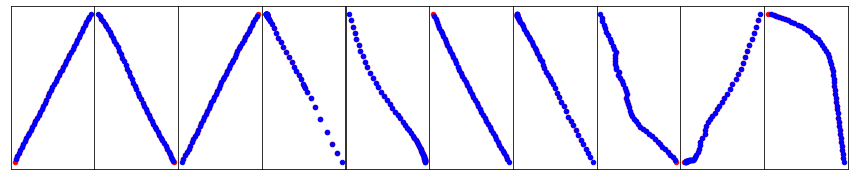

In [52]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)

    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1], c='r', s=20)
        axs[i].scatter(out[i,:,0], out[i,:,1], c='b', s=20)
    

for i_batch, sample_batch in enumerate(train_loader):
    if i_batch != 4: continue
    inputs, outputs = sample_batch
    show_sample_batch(sample_batch)
    break




## Create Model

In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

from torch import nn

class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=2, hidden_size=512, num_layers=3, dropout=0.5, batch_first=True)
        self.linear = nn.Linear(512, 256)
        self.dropout = nn.Dropout(0.5)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(256, 2)

    def forward(self, x, h=None, c=None):
        if (h is not None) and (c is not None):
            x, (h, c) = self.lstm(x, (h, c))
        else:
            x, (h, c) = self.lstm(x)
        x = self.linear(x)
        x = self.dropout(x)
        x = self.tanh(x)
        x = self.linear2(x)
        return x, h, c
        

Using device: cpu


## Train Model

In [54]:
num_epochs = 15
learning_rate = 0.001

lstm = LSTM()
lstm.to(device)
optimizer = torch.optim.Adam(lstm.parameters(), learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
loss_fn = nn.MSELoss()

for epoch in range(num_epochs):
    lstm.train(True)
    for i_batch, sample_batch in enumerate(train_loader):
        inp, label = sample_batch
        
        inp = inp.to(device)
        label = label.to(device)
        output, h, c = lstm(inp.float())

        loss = loss_fn(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i_batch % 10 == 0 and i_batch != 0:
            print(f"Epoch: {epoch}/{num_epochs}, Batch: {i_batch}/{len(train_loader)}, Loss: {loss.item()}")

    lstm.train(False)
    with torch.no_grad():
        for i_batch, sample_batch in enumerate(val_loader):
            inp, label = sample_batch
            inp, label = inp.to(device), label.to(device)
            output, h, c = lstm(inp.float())
            loss = loss_fn(output, label)
            print(f"Epoch: {epoch}/{num_epochs}, Batch: {i_batch}/{len(val_loader)}, Loss: {loss.item()}")

torch.save(lstm.state_dict(), "models/palo_alto_model.pt")

        

Epoch: 0/5, Batch: 10/48916, Loss: 0.35264140367507935


KeyboardInterrupt: 

## Load Model

In [110]:
lstm = LSTM()
lstm.load_state_dict(torch.load("models/austin_model.pt", map_location=device))
lstm.to(device)
lstm.train(False)

LSTM(
  (lstm): LSTM(2, 512, num_layers=3, batch_first=True, dropout=0.5)
  (linear): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (tanh): Tanh()
  (linear2): Linear(in_features=256, out_features=2, bias=True)
  (leakyrelu): LeakyReLU(negative_slope=0.01)
)

## Sample Function

In [117]:
def sample(x, model, steps=60):
    h = None
    c = None
    arr = []
    for i in range(steps):
        output, h, c = model(x, h, c)
        if i == 0:
            print(x[0][40:-1], output[0][40:-1])
        elem = output[:, -1, :]
        x = elem.unsqueeze(1)
        elem = elem.squeeze().detach().cpu().numpy()
        arr.append(elem)
    return arr

## Make Prediction

tensor([[-0.5767,  0.2304],
        [-0.5774,  0.2307],
        [-0.5780,  0.2309],
        [-0.5786,  0.2311],
        [-0.5792,  0.2314],
        [-0.5798,  0.2316],
        [-0.5804,  0.2319],
        [-0.5810,  0.2321],
        [-0.5816,  0.2324]]) tensor([[-0.5932,  0.2529],
        [-0.5939,  0.2531],
        [-0.5945,  0.2534],
        [-0.5951,  0.2536],
        [-0.5958,  0.2539],
        [-0.5964,  0.2541],
        [-0.5970,  0.2544],
        [-0.5976,  0.2547],
        [-0.5982,  0.2549]], grad_fn=<SliceBackward0>)
tensor([[-0.8301,  0.7677],
        [-0.8300,  0.7672],
        [-0.8298,  0.7668],
        [-0.8296,  0.7663],
        [-0.8294,  0.7659],
        [-0.8292,  0.7655],
        [-0.8289,  0.7651],
        [-0.8287,  0.7647],
        [-0.8284,  0.7643]]) tensor([[-0.8742,  0.8238],
        [-0.8740,  0.8233],
        [-0.8738,  0.8228],
        [-0.8736,  0.8223],
        [-0.8734,  0.8218],
        [-0.8732,  0.8213],
        [-0.8729,  0.8209],
        [-0.8726,  

KeyboardInterrupt: 

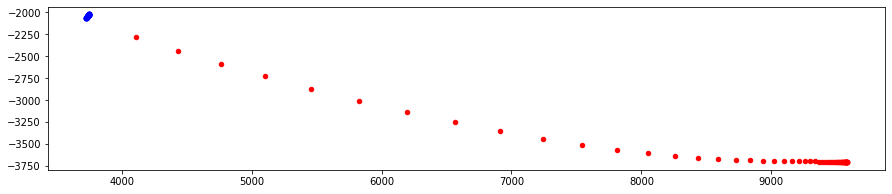

In [118]:
for i, inp in enumerate(test_loader):
    original_inp = inp
    inp = inp.to(device)
    inp = (inp - austin_mean) / austin_std
    inp = inp.float()
    output = sample(inp, lstm)

    output = np.array(output)
    output = output * austin_std + austin_mean     

    plt.figure(figsize=(15, 3))
    plt.scatter(original_inp[0][:,0], original_inp[0][:,1], c='b', s=20)
    plt.scatter(output[:,0], output[:,1], c='r', s=20)
    plt.savefig(f"outputs/austin_prediction_{i}.png")
    plt.close()
